In [1]:
import operator
import os
import re
from contextlib import asynccontextmanager
from typing import (
    List,
    Any,
    AsyncGenerator,
    TypedDict,
    Annotated,
    Literal,
)

from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import StructuredTool, render_text_description
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import create_react_agent
from langgraph.types import interrupt
from pydantic import BaseModel

from agents.consts import (
    DISCREPANCY_TEMPLATE,
    SUPERVISOR_TEMPLATE,
    FEEDBACK_TEMPLATE,
    GUIDANCE_TEMPLATE,
    MODERATION_TEMPLATE,
)
from agents.dto import AgentMessage, ChatMessage
from agents.reasoner import get_checkpointer
from logger import logger
from tools.tools import find_current_grade_for_user_and_skill, get_grades_or_expertise
from utils.common import convert_agent_msg_to_llm_message

load_dotenv()

search = TavilySearchResults()

LITE_LLM_API_KEY = os.getenv("OPENAI_API_KEY")
LITE_LLM_URL = os.getenv("OPENAI_BASE_URL")
LITE_MODEL = os.getenv("OPENAI_MODEL")


TRACING_DISCREPANCY_AGENT = "discrepancy_agent"
TRACING_GUIDANCE_AGENT = "guidance_agent"
TRACING_SUPERVISOR_AGENT = "supervisor_agent"
TRACING_FEEDBACK_AGENT = "feedback_agent"
TRACING_GRADING_AGENT = "grading_agent"
TRACING_EVADE_AGENT = "evasion_detector_agent"
TRACING_START = "start"
TRACING_END = "end"
TRACING_FINISH = "finish"
TRACING_NEXT_STEP = "next_step"
MODERATION_NODE = "moderation"
SUPERVISOR_NODE = "supervisor"
FEEDBACK_NODE = "feedback"
GRADING_NODE = "grading"
EVADE_NODE = "evasion_detector"
DISCREPANCY_NODE = "discrepancy"
GUIDANCE_NODE = "guidance"
FINISH_NODE = "finish"


class DiscrepancyValues(BaseModel):
    """
    Represents discrepancy values with associated grade, skill, and user.

    This class is used to define and manipulate the discrepancy values. It tracks
    the grade, skill, and user identifiers, which can be utilized in data processing
    or analysis involving discrepancies.

    :ivar grade_id: Identifier for the grade.
    :type grade_id: int
    :ivar skill_id: Identifier for the skill.
    :type skill_id: int
    :ivar user_id: Identifier for the user.
    :type user_id: int
    """

    grade_id: int
    skill_id: int
    user_id: int


class GuidanceValue(BaseModel):
    """
    Represents a value guided by a list of messages with specific annotations.

    This class is used to encapsulate a collection of messages, allowing
    additional modifications or processing based on their annotations.

    :ivar messages: A list of messages annotated with `add_messages`.
    :type messages: list
    """

    messages: Annotated[list, add_messages]


class SupervisorState(TypedDict):
    """
    Represents a state used by a supervisor system for managing and guiding agent
    interactions.

    This class is a typed dictionary designed to store and validate the various
    components of the supervisor's state. The state includes details about
    discrepancies, guidance information, next steps for agents, messages, and chat
    messages. Each key corresponds to a specific component used in the supervision
    process, ensuring data consistency and structure throughout the workflow.

    :ivar discrepancy: Represents the discrepancies in the current state that might
                       require attention or adjustment.
    :type discrepancy: DiscrepancyValues
    :ivar guidance: Specifies the guidance value that provides corrective or
                    directive feedback within the system.
    :type guidance: GuidanceValue
    :ivar next_steps: A list of next steps (strings) annotated with specifications
                      for operational behavior.
    :type next_steps: Annotated[List[str], operator.add]
    :ivar messages: A list of agent-specific messages annotated with specifications
                    for operational behavior.
    :type messages: Annotated[List[AgentMessage], operator.add]
    :ivar chat_messages: A list of chat-specific messages annotated with
                         specifications for operational behavior.
    :type chat_messages: Annotated[List[ChatMessage], operator.add]
    """

    discrepancy: DiscrepancyValues
    guidance: GuidanceValue
    next_steps: Annotated[List[str], operator.add]
    messages: Annotated[List[AgentMessage], operator.add]
    chat_messages: Annotated[List[ChatMessage], operator.add]


def extract_to_ai_and_human_msgs() -> List[AIMessage | HumanMessage | SystemMessage]:
    pass


async def moderation_agent(state: SupervisorState) -> SupervisorState:
    """
    Analyzes and processes the provided state to detect and handle inappropriate content.
    This function operates asynchronously, utilizing the capabilities defined in
    the SupervisorState object. It ensures inappropriate content within the given state
    is properly addressed, updating the state accordingly.

    :param state: The current SupervisorState instance containing information regarding
                  the system state and content to analyze.
    :type state: SupervisorState
    :return: An updated SupervisorState instance with processed changes applied.
    :rtype: SupervisorState
    """
    model = ChatOpenAI(
        temperature=0,
        max_tokens=300,
        model=LITE_MODEL,
        api_key=LITE_LLM_API_KEY,
        base_url=LITE_LLM_URL,
        streaming=True,
        verbose=True,
    )
    prompt_template = ChatPromptTemplate.from_messages(
        [
            SystemMessage(MODERATION_TEMPLATE)
            + [
                (
                    AIMessage(msg["message"])
                    if msg["role"] == "ai"
                    else HumanMessage(msg["message"])
                )
                for msg in state["chat_messages"]
            ]
        ]
    )
    prompt = await prompt_template.ainvoke({})
    print(f"\n\nMODERATION PROMPT\n {prompt}")
    response = await model.ainvoke(prompt)
    print(f"\n\nMODERATION RESPONSE\n {response}")

    return state


async def discrepancy_agent(state: SupervisorState) -> SupervisorState:
    """
    Executes the discrepancy checking process for a user and skill and provides
    corresponding guidance and messages based on discrepancies identified.

    :param state: The current state of the process, which contains information
        about the discrepancy, guidance, next steps, and chat messages.
    :type state: SupervisorState
    :return: The updated state containing the discrepancy information, guidance,
        next steps, and any generated agent messages.
    :rtype: SupervisorState
    """
    tools = [
        StructuredTool.from_function(
            function=find_current_grade_for_user_and_skill,
            coroutine=find_current_grade_for_user_and_skill,
        ),
        StructuredTool.from_function(
            function=get_grades_or_expertise,
            coroutine=get_grades_or_expertise,
        ),
    ]
    model = ChatOpenAI(
        temperature=0,
        max_tokens=300,
        model=LITE_MODEL,
        api_key=LITE_LLM_API_KEY,
        base_url=LITE_LLM_URL,
        streaming=True,
        verbose=True,
    )

    msgs = []
    for msg in state["chat_messages"]:
        if msg["role"] == "human":
            answer = f"Answer: {msg["message"]}"
            msgs.append(answer)
        elif msg["role"] == "ai":
            question = f"Question: {msg["message"]}"
            msgs.append(question)
    prompt_msgs = "\n".join(msgs)

    prompt_template = ChatPromptTemplate.from_template(DISCREPANCY_TEMPLATE)
    prompt = await prompt_template.ainvoke(
        input={
            "user_id": state["discrepancy"].user_id,
            "skill_id": state["discrepancy"].skill_id,
            "current_grade": state["discrepancy"].grade_id,
            "discussion": prompt_msgs,
        }
    )
    print(f"\n\nDISCREPANCY AGAIN PROMPT\n {prompt}")
    logger.info(f"\n\nDISCREPANCY AGAIN PROMPT\n {prompt}")
    agent = create_react_agent(model=model, tools=tools)
    response = await agent.ainvoke(prompt)
    print(f"\n\nDISCREPANCY AGAIN RESPONSE\n {response}")
    logger.info(f"\n\nDISCREPANCY AGAIN RESPONSE\n {response}")
    msg = []
    if "messages" in response and len(response["messages"]) > 0:
        response_msgs = response["messages"][-1]
        msg = [
            AgentMessage(
                message=response_msgs,
                role="discrepancy",
            )
        ]
    return {
        "discrepancy": state["discrepancy"],
        "guidance": state["guidance"],
        "next_steps": state["next_steps"],
        "messages": msg,
        "chat_messages": [],
    }


async def supervisor_agent(state: SupervisorState) -> SupervisorState:
    """
    Executes the supervisor agent logic asynchronously, processing the current state
    and generating an updated state that includes extracted next steps, messages, and
    chat messages. The supervisor agent composes a discussion prompt, invokes a language
    model for response generation, and determines the appropriate next steps based on the
    content of the response.

    :param state: The current state of the supervisor, containing all relevant
        information such as chat messages, discrepancies, guidance, and
        agent messages.
    :type state: SupervisorState
    :return: A dictionary representing the updated state of the supervisor. It includes
        any detected discrepancies, new guidance, next steps determined for the agent,
        messages processed by the supervisor, and any additional chat messages to append.
    :rtype: SupervisorState
    """
    prompt_template = ChatPromptTemplate.from_template(SUPERVISOR_TEMPLATE)
    msgs = []
    for msg in state["chat_messages"]:
        if msg["role"] == "human":
            answer = f"Answer: {msg["message"]}"
            msgs.append(answer)
        elif msg["role"] == "ai":
            question = f"Question: {msg["message"]}"
            msgs.append(question)
    prompt_msgs = "\n".join(msgs)
    scratchpad_msgs = [m.message.content for m in state["messages"]]
    scratchpad_msgs_str = "\n".join(scratchpad_msgs)
    prompt = await prompt_template.ainvoke(
        {"discussion": prompt_msgs, "agent_scratchpad": scratchpad_msgs_str}
    )
    print(f"\n\nSUPERVISOR AGENT PROMPT\n {prompt}")

    model = ChatOpenAI(
        temperature=0,
        max_tokens=300,
        model=LITE_MODEL,
        api_key=LITE_LLM_API_KEY,
        base_url=LITE_LLM_URL,
        streaming=True,
        verbose=True,
        stop=["\nObserve:"],
    )
    response = await model.ainvoke(prompt)
    print(f"\n\nSUPERVISOR AGENT RESPONSE\n {response}")
    content = response.content
    next_steps = []
    match = re.search(r"\nCall: (discrepancy|guidance|feedback|grading)", content)
    msg_to_append = []
    print(f"SUPERVISOR CHAT MESSAGES -> {state['chat_messages']}")
    if match:
        print("\n\n\nIS MATCHING THIS\n\n\n")
        for val in match.groups():
            next_steps.append(val)
    else:
        next_steps.append("finish")
        chat_msg = ChatMessage(
            message=response,
            role="ai",
        )
        msg_to_append.append(chat_msg)
        print("\n\n\nFINISHHHHHHH\n\n\n")

    msg = AgentMessage(
        message=response,
        role="supervisor",
    )

    return {
        "discrepancy": state["discrepancy"],
        "guidance": state["guidance"],
        "next_steps": next_steps,
        "messages": [msg],
        "chat_messages": msg_to_append,
    }


async def grading_agent(state: SupervisorState) -> SupervisorState:
    """
    Processes the given user discussion data and evaluates the user's level
    of expertise based on the provided inputs. Uses external AI models with
    a predefined message template for accurate assessment and generates
    a grade response indicating the expertise level.

    :param state: SupervisorState containing the state details including
        chat messages for the discussion, guidance, next steps, and discrepancy.
    :type state: SupervisorState
    :return: Updated SupervisorState object containing the earlier state
        along with the grading message appended after expertise evaluation.
    :rtype: SupervisorState
    """
    system_msg = """
            Based on the provided discussion your job is to confirm the level of expertise of the user!
            If you are not sure that the grade or expertise is clearly recognizable please let the the user know
            If you're certain state explicitly which expertise is correct for the user!
            Respond in format of:
            Observe: Your Answer

            Discussion:
            {discussion}
            """
    prompt_template = ChatPromptTemplate.from_template(system_msg)
    msgs = []
    for msg in state["chat_messages"]:
        if msg["role"] == "human":
            answer = f"Answer: {msg["message"]}"
            msgs.append(answer)
        elif msg["role"] == "ai":
            question = f"Question: {msg["message"]}"
            msgs.append(question)

    prompt = await prompt_template.ainvoke(input={"discussion": "\n".join(msgs)})
    model = ChatOpenAI(
        temperature=0,
        max_tokens=50,
        model=LITE_MODEL,
        api_key=LITE_LLM_API_KEY,
        base_url=LITE_LLM_URL,
        streaming=True,
        verbose=True,
    )
    response = await model.ainvoke(prompt)
    msg = AgentMessage(message=response, role="grade")
    return {
        "discrepancy": state["discrepancy"],
        "guidance": state["guidance"],
        "next_steps": state["next_steps"],
        "messages": [msg],
        "chat_messages": state["chat_messages"],
    }


async def evasion_detector_agent(state: SupervisorState) -> SupervisorState:
    prompt_template = ChatPromptTemplate.from_template(
        """
        From provided discussion, check whether the user is evading to answer a provided question?

        Discussion:
        {}

        Respond in the following format:
        Observe: Your answer
        """
    )
    return state


async def feedback_agent(state: SupervisorState) -> SupervisorState:
    """
    Asynchronously processes feedback for a given supervisor state using an AI chat
    model and generates a response. This function utilizes an AI model to analyze
    the provided supervisor state and generates feedback based on the state’s
     attributes, including its messages and discrepancy information. The resulting
    feedback is returned alongside updated state information.

    :param state: A SupervisorState object representing the current state of
                  the supervisor, including messages and other details to guide
                  the feedback process.
    :type state: SupervisorState
    :return: A SupervisorState object containing the updated state with feedback
             responses and new messages integrated into the state.
    :rtype: SupervisorState
    """
    model = ChatOpenAI(
        temperature=0,
        max_tokens=300,
        model=LITE_MODEL,
        api_key=LITE_LLM_API_KEY,
        base_url=LITE_LLM_URL,
        streaming=True,
        verbose=True,
    )
    msgs = convert_agent_msg_to_llm_message(state["messages"])
    print(f"\n\nFEEDBACK AGENT PROMPT\n {msgs}")
    print(f"\n\nFEEDBACK AGENT PROMPT\n {state['chat_messages'][-1]}")
    prompt_template = ChatPromptTemplate.from_messages(
        [SystemMessage(FEEDBACK_TEMPLATE)] + msgs
    )
    prompt = await prompt_template.ainvoke(input={})
    feedback_response = await model.ainvoke(prompt)

    interrupt_val = {
        "answer_to_revisit": feedback_response.content,
    }
    print(f"\n\nFEEDBACK AGENT\n {interrupt_val}")
    print(f"\n\nFEEDBACK RESPONSE\n {feedback_response}")
    agent_msg = AgentMessage(
        message=interrupt(
            interrupt_val,
        ),
        role="feedback",
    )
    msg_for_user = ChatMessage(
        message=feedback_response,
        role="ai",
    )

    return {
        "discrepancy": state["discrepancy"],
        "guidance": state["guidance"],
        "next_steps": state["next_steps"],
        "messages": [agent_msg],
        "chat_messages": [msg_for_user],
    }


async def guidance_agent(state: SupervisorState) -> SupervisorState:
    """
    Executes the guidance agent workflow using the provided state. This function builds a
    compatible prompt, uses ChatOpenAI for processing, and generates an appropriate
    response from the agent. The response is then structured and prepared for return.

    :param state: Current state passed to the guidance agent. The state must implement
                  the SupervisorState structure.
    :type state: SupervisorState
    :return: Updated state containing the guidance agent's reply and other relevant
             elements, structured for further use.
    :rtype: SupervisorState
    """
    print("\n\n\nENTERING GUIDANCE\n\n\n")
    tools = [search]
    msgs = []
    for msg in state["chat_messages"]:
        if msg["role"] == "human":
            msgs.append(f"Answer: {msg['message']}")
        elif msg["role"] == "ai":
            msgs.append(f"Question: {msg['message']}")
    msgs_str = "\n".join(msgs)
    template = ChatPromptTemplate.from_template(GUIDANCE_TEMPLATE)
    prompt = await template.ainvoke(
        input={"tools": render_text_description(tools), "discussion": msgs_str}
    )
    model = ChatOpenAI(
        temperature=0,
        max_tokens=300,
        model=LITE_MODEL,
        api_key=LITE_LLM_API_KEY,
        base_url=LITE_LLM_URL,
        streaming=True,
        verbose=True,
    )
    print(f"\n\nGUIDANCE AGENT PROMPT\n {prompt}")
    agent = create_react_agent(model=model, tools=tools)
    agent_response = await agent.ainvoke(prompt)
    print(f"\n\nGUIDANCE AGENT RESPONSE\n {agent_response}")
    msg = AgentMessage(
        message=agent_response["messages"][-1],
        role="guidance",
    )
    return {
        "discrepancy": state["discrepancy"],
        "guidance": state["guidance"],
        "next_steps": state["next_steps"],
        "messages": [msg],
        "chat_messages": [],
    }


async def finish(state: SupervisorState) -> SupervisorState:
    return state


async def next_step(
    state: SupervisorState,
) -> Literal["guidance", "feedback", "discrepancy", "finish", "grading"]:
    if len(state["next_steps"]) > 0:
        if state["next_steps"][-1] == GUIDANCE_NODE:
            return GUIDANCE_NODE
        elif state["next_steps"][-1] == DISCREPANCY_NODE:
            return DISCREPANCY_NODE
        elif state["next_steps"][-1] == FEEDBACK_NODE:
            return FEEDBACK_NODE
        elif state["next_steps"][-1] == GRADING_NODE:
            return GRADING_NODE
    return FINISH_NODE


@asynccontextmanager
async def get_graph() -> AsyncGenerator[CompiledStateGraph, Any]:
    try:
        async with get_checkpointer() as saver:
            state_graph = StateGraph(SupervisorState)
            state_graph.add_node(MODERATION_NODE, moderation_agent)
            state_graph.add_node(SUPERVISOR_NODE, supervisor_agent)
            state_graph.add_node(DISCREPANCY_NODE, discrepancy_agent)
            state_graph.add_node(GUIDANCE_NODE, guidance_agent)
            state_graph.add_node(FEEDBACK_NODE, feedback_agent)
            state_graph.add_node(GRADING_NODE, grading_agent)
            state_graph.add_node(FINISH_NODE, finish)
            state_graph.add_edge(START, MODERATION_NODE)
            state_graph.add_edge(MODERATION_NODE, SUPERVISOR_NODE)
            state_graph.add_conditional_edges(SUPERVISOR_NODE, next_step)
            state_graph.add_edge(DISCREPANCY_NODE, SUPERVISOR_NODE)
            state_graph.add_edge(GUIDANCE_NODE, SUPERVISOR_NODE)
            state_graph.add_edge(FEEDBACK_NODE, SUPERVISOR_NODE)
            state_graph.add_edge(GRADING_NODE, SUPERVISOR_NODE)
            state_graph.add_edge(FINISH_NODE, END)

            graph = state_graph.compile(checkpointer=saver)
            yield graph
    finally:
        print("Cleaning up")

/Users/danijeldjuric/.local/share/virtualenvs/l2work-p89lVMS_/lib/python3.13/site-packages/google/rpc/__init__.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/var/folders/hd/7h19m8yx5fq36c338t78m1k80000gn/T/ipykernel_46303/2141962704.py:41: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search = TavilySearchResults()


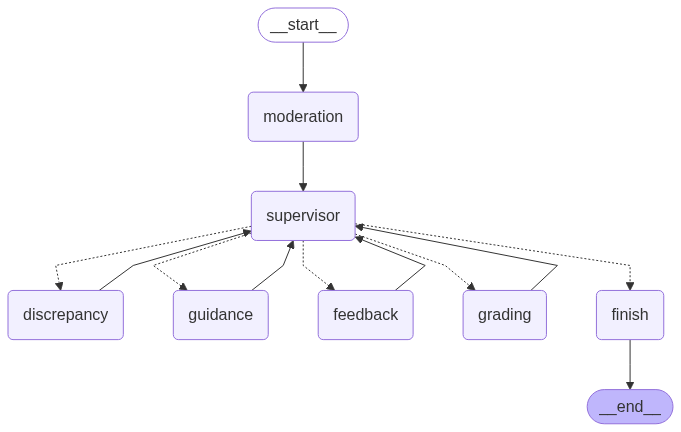

Cleaning up


In [2]:
from IPython.core.display import Image

async with get_graph() as graph:
    display(Image(graph.get_graph().draw_mermaid_png()))